# Створення базових моделей

**Частина 1**

Необхідно визначити в коді натупне:

1. Базову модель для навчання (виберіть який тип моделі хочете натренувати CNN, MLP тощо).
2. Початкову кількість шарів та їх параметри.
3. Функції для тренування та валідації, візуалізації результатів, фінкцію втрат та метрику перевірки результатів.
4. Натренуйте модель і перевірте результат. Яке значення функції втрат, яка метрика вашої моделі після навчання? Візуалізуйте графіки навчання. Скільки часу потрібно було на тренування?

**Частина 2**

1. Опишіть гіперпараметри моделі: кількість шарів/кількість нейронів в шарах, різні їх комбінації.
2. Підберіть та перевірте найкращі гіперпараметри вашої моделі за яких метрика під час валідації буде найвищою. Скільки часу потрібно було на підбір гіперпараметрів моделі?
3. Продемонструйте на яких класах та зображеннях найчастіше помиляється найкраща модель.
4. Візуалізувати графіки залежностей між гіперпараметрами найкращої моделі і змінами значень її метрики.

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
datasets_path = './datasets'

train_dataset = FashionMNIST(
    datasets_path,
    train=True,
    download=True,
    transform=transform
)

validation_dataset = FashionMNIST(
    datasets_path,
    train=False,
    transform=transform
)

In [5]:
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(dataset=validation_dataset, shuffle=False)

In [6]:
class CustomNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        super().__init__()
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.ModuleList(layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [22]:
def train(model, optimizer, criterion, epoch, log_interval=200):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.06f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.data.item()))

In [23]:
def validate(model, criterion, loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    print('Validation set: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n'.format(val_loss, correct, len(validation_loader.dataset), accuracy))

In [ ]:
%%time

model = CustomNetwork(act_fn=nn.ReLU()).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(model, optimizer, criterion, epoch, log_interval = 1000)
    validate(model, criterion, lossv, accv)

plt.figure(figsize=(5,3))
plt.plot(np.arange(1, epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1, epochs+1), accv)
plt.title('validation accuracy')

Частина 2: створення декількох моделей і порівніння

In [64]:
all_models_combination = []

model = CustomNetwork(act_fn=nn.ReLU())
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()
all_models_combination.append({"model": model, "optimizer": optimizer, "criterion": criterion, "name": "default", "color": "g"})

model = CustomNetwork(act_fn=nn.ReLU())
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
criterion = nn.CrossEntropyLoss()
all_models_combination.append({"model": model, "optimizer": optimizer, "criterion": criterion, "name": "lr=0.05", "color": "b"})

model = CustomNetwork(act_fn=nn.ReLU(), hidden_sizes=[512, 256, 256, 128, 64, 16])
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
criterion = nn.CrossEntropyLoss()
all_models_combination.append({"model": model, "optimizer": optimizer, "criterion": criterion, "name": "lr=0.05 + hidden_sizes=[512, 256, 256, 128, 64, 16]", "color": "m"})

model = CustomNetwork(act_fn=nn.ELU())
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()
all_models_combination.append({"model": model, "optimizer": optimizer, "criterion": criterion, "name": "activation=ELU", "color": "y"})

In [65]:
for setup in all_models_combination:
    print("working with model: " + setup['name'])
    setup['model'] = setup['model'].to(device)
    
    epochs = 5
    
    lossv, accv = [], []
    for epoch in range(1, epochs + 1):
        train(setup['model'], setup['optimizer'], setup['criterion'], epoch, log_interval = 500)
        validate(setup['model'], setup['criterion'], lossv, accv)
    setup['loss'] = lossv
    setup['acc'] = accv

print("completed")

working with model: default
Train epoch: 1 [0/60000 (0%)]	loss: 2.302655
Train epoch: 1 [16000/60000 (27%)]	loss: 1.330322
Train epoch: 1 [32000/60000 (53%)]	loss: 1.034994
Train epoch: 1 [48000/60000 (80%)]	loss: 0.802658
Validation set: average loss: 0.6681, accuracy: 7655/10000 (77%)

Train epoch: 2 [0/60000 (0%)]	loss: 1.096018
Train epoch: 2 [16000/60000 (27%)]	loss: 0.355884
Train epoch: 2 [32000/60000 (53%)]	loss: 0.739810
Train epoch: 2 [48000/60000 (80%)]	loss: 0.466492
Validation set: average loss: 0.5842, accuracy: 7921/10000 (79%)

Train epoch: 3 [0/60000 (0%)]	loss: 0.398096
Train epoch: 3 [16000/60000 (27%)]	loss: 0.226165
Train epoch: 3 [32000/60000 (53%)]	loss: 0.668671
Train epoch: 3 [48000/60000 (80%)]	loss: 0.600370
Validation set: average loss: 0.4626, accuracy: 8343/10000 (83%)

Train epoch: 4 [0/60000 (0%)]	loss: 0.460349
Train epoch: 4 [16000/60000 (27%)]	loss: 0.367474
Train epoch: 4 [32000/60000 (53%)]	loss: 0.496942
Train epoch: 4 [48000/60000 (80%)]	loss: 0.2

Text(0.5, 1.0, 'validation accuracy')

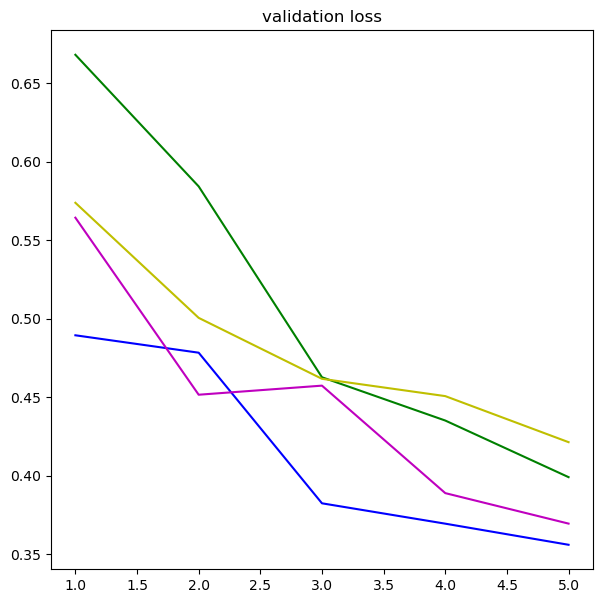

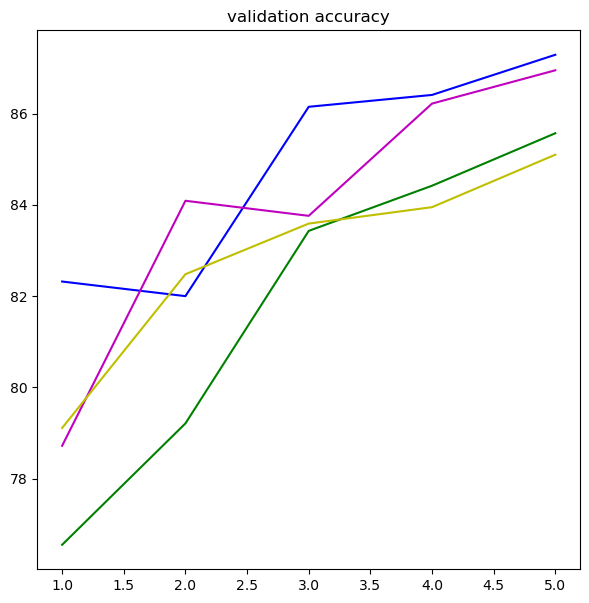

In [90]:
# print common grapth for all models

plt.figure(figsize=(7,7))
for setup in all_models_combination:
    plt.plot(np.arange(1, epochs+1), setup['loss'], color=setup['color'])
plt.title('validation loss')


plt.figure(figsize=(7,7))
for setup in all_models_combination:
    plt.plot(np.arange(1, epochs+1), setup['acc'], color=setup['color'])
plt.title('validation accuracy')


In [84]:
print('model with lowest loss: ' + min(all_models_combination, key=lambda x: x['loss'])['name'])
print('model with highest loss: ' + max(all_models_combination, key=lambda x: x['loss'])['name'])
print('model with lowest accuracy: ' + min(all_models_combination, key=lambda x: x['acc'])['name'])
print('model with highest accuracy: ' + max(all_models_combination, key=lambda x: x['acc'])['name'])

model with lowest loss: lr=0.05
model with highest loss: default
model with lowest accuracy: default
model with highest accuracy: lr=0.05
